In [1]:
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import norm

In [2]:
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Calibri"
matplotlib.rcParams['font.size'] = 14

In [4]:
def add_noise_2d(arr, ratio):
    rands = np.random.rand(arr.shape[0] * arr.shape[1])
    condition = rands < ratio
    mask = np.flatnonzero(condition)
    f = arr.flatten()
    f[mask] *= -1
    return f.reshape(arr.shape)

# Import model

In [5]:
from minerva2 import Minerva2

# Rhythm/Tone Experiment

TypeError: add_traces() missing 1 required positional argument: 'noise_ratio'

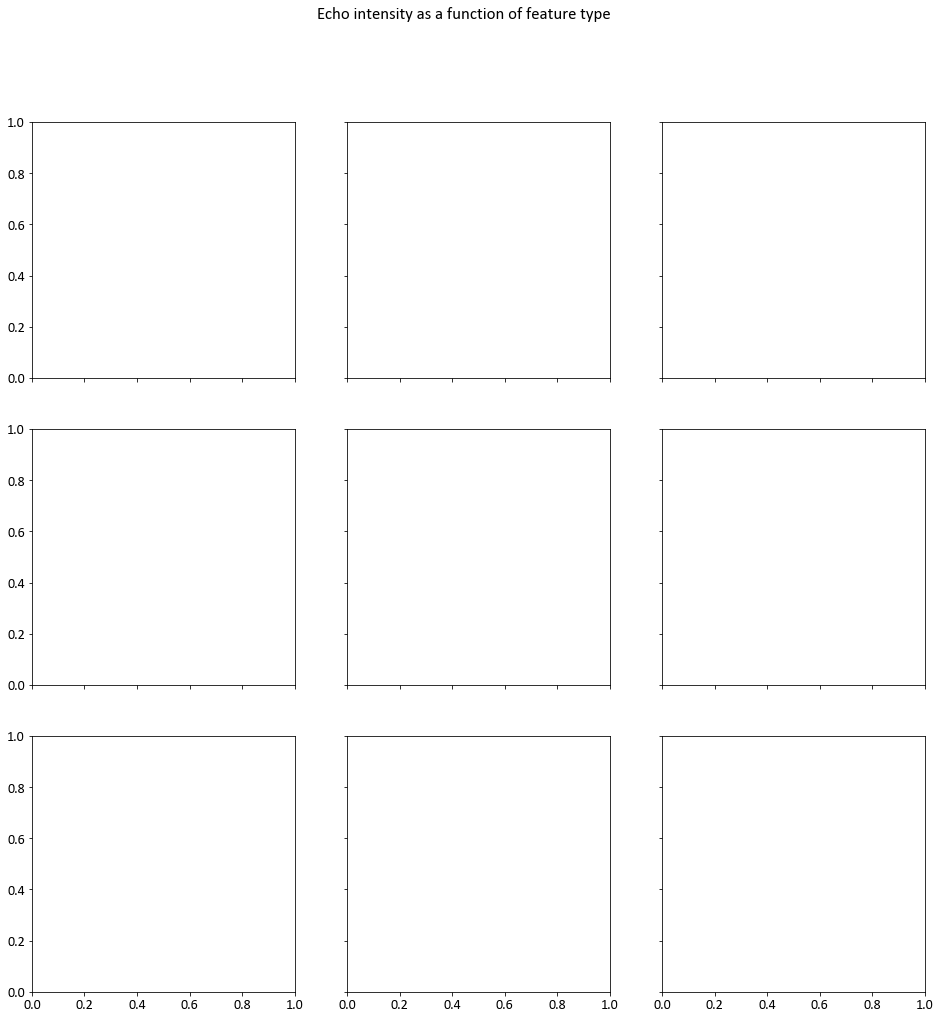

In [6]:
# tunable variables
FPT = 1000
N_PROTOTYPES = 30

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_figheight(16)
fig.set_figwidth(16)
fig.suptitle("Echo intensity as a function of feature type")

for i, TONE_RHYTHM_RATIO in enumerate([.5, .6, .7]):
    for j, NOISE_RATIO in enumerate([0.01, 0.1, 0.2]):
        tone_intensities = []
        rhythm_intensities = []
        both_intensities = []
        unstudied_intensities = []
        for _ in range(120):
            # create model
            model = Minerva2(FPT)

            # create probes
            Ps_unstudied = np.random.randint(-1, 2, (N_PROTOTYPES, FPT))
            Ps_both = np.random.randint(-1, 2, (N_PROTOTYPES, FPT))
            Ps_rhythm = np.random.randint(-1, 2, (N_PROTOTYPES, FPT))
            Ps_tone = np.random.randint(-1, 2, (N_PROTOTYPES, FPT))

            # create traces (subset of probes)
            T_Rs = np.copy(Ps_rhythm)
            T_Ts = np.copy(Ps_tone)
            T_B_Rs = np.copy(Ps_both)
            T_B_Ts = np.copy(Ps_both)

            # zero out parts of traces (symmetrically)
            RT_split_index = round(FPT * TONE_RHYTHM_RATIO)

            T_Rs[:, :RT_split_index] *= 0
            T_Ts[:, RT_split_index:] *= 0
            T_B_Rs[:, RT_split_index:] *= 0
            T_B_Ts[:, :RT_split_index] *= 0

            # flip some features (add noise)
            T_Rs = add_noise_2d(T_Rs, NOISE_RATIO)
            T_Ts = add_noise_2d(T_Ts, NOISE_RATIO)
            T_B_Rs = add_noise_2d(T_B_Rs, NOISE_RATIO)
            T_B_Ts = add_noise_2d(T_B_Ts, NOISE_RATIO)

            # add traces to model
            model.add_traces(T_Rs)
            model.add_traces(T_Ts)
            model.add_traces(T_B_Rs)
            model.add_traces(T_B_Ts)

            # get echo intensities
            tone_intensities.extend(model.get_echo_intensities(Ps_tone))
            rhythm_intensities.extend(model.get_echo_intensities(Ps_rhythm))
            both_intensities.extend(model.get_echo_intensities(Ps_both))
            unstudied_intensities.extend(model.get_echo_intensities(Ps_unstudied))

        # plot histograms and normal PDFs
        mu_tone, std_tone = norm.fit(tone_intensities)
        mu_rhythm, std_rhythm = norm.fit(rhythm_intensities)
        mu_both, std_both = norm.fit(both_intensities)
        mu_unstudied, std_unstudied = norm.fit(unstudied_intensities)

        print(i, j)
        axs[i, j].hist(unstudied_intensities, color='xkcd:orange', density=True)
        axs[i, j].hist(tone_intensities, color='b', density=True)
        axs[i, j].hist(rhythm_intensities, color='g', density=True)
        axs[i, j].hist(both_intensities, color='r', density=True)
        #plt.xlim(-1e-4, .001)
        xmin, xmax = axs[i, j].set_xlim(-1e-4, .001)
        x = np.linspace(xmin, xmax, 10000)
        axs[i, j].set_ylim(0, 60000)

        p_unstudied = norm.pdf(x, mu_unstudied, std_unstudied)
        axs[i, j].plot(x, p_unstudied, 'k',linewidth=4)
        axs[i, j].plot(x, p_unstudied, 'xkcd:orange',linewidth=2, label='UNSTUDIED: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_unstudied, std_unstudied))

        p_tone = norm.pdf(x, mu_tone, std_tone)
        axs[i, j].plot(x, p_tone, 'k',linewidth=4)
        axs[i, j].plot(x, p_tone, 'b',linewidth=2, label='TONE: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_tone, std_tone))

        p_rhythm = norm.pdf(x, mu_rhythm, std_rhythm)
        axs[i, j].plot(x, p_rhythm, 'k',linewidth=4)
        axs[i, j].plot(x, p_rhythm, 'g',linewidth=2, label='RHYTHM: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_rhythm, std_rhythm))

        p_both = norm.pdf(x, mu_both, std_both)
        axs[i, j].plot(x, p_both, 'k',linewidth=4)
        axs[i, j].plot(x, p_both, 'r',linewidth=2, label='BOTH: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_both, std_both))

        axs[i, j].set_title("Noise ratio={}, R/T ratio={}".format(NOISE_RATIO, TONE_RHYTHM_RATIO))
        axs[i, j].set_xlabel("Echo Intensity")
        axs[i, j].set_ylabel("Density")
        axs[i, j].grid(True)
        axs[i, j].legend(loc=1, prop={'size':13.5})
        axs[i, j].label_outer()
        
        with open("Simulations_TR_Output_{}_{}.csv".format(i,j),"w") as potato:
            potato.write("unstudied,tone,rhythm,both\n")
            for u,t,r,b in zip(unstudied_intensities, tone_intensities, rhythm_intensities, both_intensities):
                #potato.write(str(u)+str(t)+str(r)+str(b)+"\n")
                potato.write('{},{},{},{}\n'.format(u,t,r,b))
                
        labels = ['U','T','R','B']
        results = [unstudied_intensities, tone_intensities, rhythm_intensities, both_intensities]
        print('_,U,T,R,B')
        for k, row in enumerate(results):
            print(labels[k], end=',')
            for col in results:
                print(ttest_ind(row, col).pvalue, end=',')
            print()
            

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


# Repetition Experiment

In [ ]:
# tunable variables
FPT = 1000
N_PROTOTYPES = 40
N=3

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_figheight(16)
fig.set_figwidth(16)
fig.suptitle("Echo intensity as a function of repetition")

for i, TONE_RHYTHM_RATIO in enumerate([.5, .6, .7]):
    for j, NOISE_RATIO in enumerate([0.01, 0.1, 0.2]):
        print(i, j)
        R1_intensities = []
        RN_intensities = []
        unstudied_intensities = []
        for _ in range(120):
            model = Minerva2(FPT)

            # create probes
            Ps_unstudied = np.random.randint(-1, 2, (N_PROTOTYPES, FPT))
            Ps_rhythm1 = np.random.randint(-1, 2, (N_PROTOTYPES, FPT))
            Ps_rhythmN = np.random.randint(-1, 2, (N_PROTOTYPES, FPT))

            # create traces (subset of probes)
            T_1s = np.copy(Ps_rhythm1)
            T_Ns = np.copy(Ps_rhythmN)

            # zero out parts of traces (symmetrically)
            RT_split_index = round(FPT * TONE_RHYTHM_RATIO)

            T_1s[:, :RT_split_index] *= 0
            T_Ns[:, :RT_split_index] *= 0

            # flip some features (add noise)
            T_1s = add_noise_2d(T_1s, NOISE_RATIO)
            T_Ns = add_noise_2d(T_Ns, NOISE_RATIO)

            # add traces to model
            model.add_traces(T_1s)
            for _ in range(N):
                model.add_traces(T_Ns)

            # get echo intensities
            R1_intensities.extend(model.get_echo_intensities(Ps_rhythm1))
            RN_intensities.extend(model.get_echo_intensities(Ps_rhythmN))
            unstudied_intensities.extend(model.get_echo_intensities(Ps_unstudied))

        # plot histograms and normal PDFs
        mu_1, std_1 = norm.fit(R1_intensities)
        mu_N, std_N = norm.fit(RN_intensities)
        mu_unstudied, std_unstudied = norm.fit(unstudied_intensities)

        axs[i, j].hist(unstudied_intensities, color='xkcd:orange', density=True)
        axs[i, j].hist(R1_intensities, color='b', density=True)
        axs[i, j].hist(RN_intensities, color='g', density=True)
        x = np.linspace(xmin, xmax, 10000)
        xmin, xmax = axs[i, j].set_xlim(-1e-4, .0012)
        axs[i, j].set_ylim(0, 90000)

        p_unstudied = norm.pdf(x, mu_unstudied, std_unstudied)
        axs[i, j].plot(x, p_unstudied, 'k',linewidth=4)
        axs[i, j].plot(x, p_unstudied, 'xkcd:orange',linewidth=2, label='UNSTUDIED: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_unstudied, std_unstudied))

        p_1 = norm.pdf(x, mu_1, std_1)
        axs[i, j].plot(x, p_1, 'k',linewidth=4)
        axs[i, j].plot(x, p_1, 'b',linewidth=2, label='N=1: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_1, std_1))

        p_N = norm.pdf(x, mu_N, std_N)
        axs[i, j].plot(x, p_N, 'k',linewidth=4)
        axs[i, j].plot(x, p_N, 'g',linewidth=2, label='N=3: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_N, std_N))

        axs[i, j].set_title("Noise ratio={}, R/T ratio={}".format(NOISE_RATIO, TONE_RHYTHM_RATIO))
        axs[i, j].set_xlabel("Echo Intensity")
        axs[i, j].set_ylabel("Density")
        axs[i, j].grid(True)
        axs[i, j].legend(loc=1, prop={'size':13.5})
        axs[i, j].label_outer()
        
        with open("Simulations_Repetition_Output_{}_{}.csv".format(i,j),"w") as potato:
            potato.write("unstudied,r1,r3\n")
            for u,r1,r3 in zip(unstudied_intensities, R1_intensities, RN_intensities):
                potato.write('{},{},{}\n'.format(u,r1,r3))  
                
        labels = ['U','1','N']
        results = [unstudied_intensities, R1_intensities, RN_intensities]
        print('_,U,1,N')
        for k, row in enumerate(results):
            print(labels[k], end=',')
            for col in results:
                print(ttest_ind(row, col).pvalue, end=',')
            print()
            

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
